In [170]:
import os
import glob
import nltk
import copy
import math
import torch
import random
import numpy as np
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pack_padded_sequence as pack
from torch.nn.utils.rnn import pad_packed_sequence as unpack


from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [153]:
class Vocab:
    def __init__(self, counter, sos, eos, pad, unk, min_freq=None):
        self.sos = sos
        self.eos = eos
        self.pad = pad
        self.unk = unk
        
        self.pad_idx = 0
        self.unk_idx = 1

        
        self._token2idx = {
            self.pad: self.pad_idx,
            self.unk: self.unk_idx,
        }
        self._idx2token = {idx:token for token, idx in self._token2idx.items()}
        
        idx = len(self._token2idx)
        min_freq = 0 if min_freq is None else min_freq
        
        for token, count in counter.items():
            if count > min_freq:
                self._token2idx[token] = idx
                self._idx2token[idx]   = token
                idx += 1
        
        self.vocab_size = len(self._token2idx)
        self.tokens     = list(self._token2idx.keys())
    
    def token2idx(self, token):
        return self._token2idx.get(token, self.pad_idx)
    
    def idx2token(self, idx):
        return self._idx2token.get(idx, self.pad)
    
    def __len__(self):
        return len(self._token2idx)

def pad_contexts(list_):
    
    length_dict = {key: len(value) for key, value in d.items()}
    
def pad_many_seq(sequences, pad_idx, max_length):
    '''
    Inputs:
        sequences: list of list of tokens
    '''    
    return [ seq + [pad_idx]*(max_length - len(seq)) for seq in sequences]

def pad_single_seq(sequence, pad_idx, max_length):
    '''
    Inputs:
        sequence: list of tokens
    '''    
    return sequence + [pad_idx]*(max_length - len(sequence))

def pad_body(sequences, pad_idx, max_length, max_seq_length):
    '''
    Inputs:
        sequences: list of list of tokens
    '''    
    return sequences + [torch.zeros(max_seq_length)] * (max_length - len(sequences))
        
def words_tokenize(line):
    return  nltk.word_tokenize(line)

In [154]:
class Dataset(object):
    def __init__(self, path, val):
        
        
        shuffle  = True
        self.val = val
        self.data = []
        primal_data = []
        context = []

        dict_cell = {}
      
        with open(path) as f:
            file_content = f.readlines()
            for x in file_content:

                line = nltk.word_tokenize(x)
               
                if line[0] == '1':
                    del context
                    context = []

                if '?' in line:
                    dict_cell['question'] = line[1:line.index('?') + 1]
                    dict_cell['context'] =  copy.deepcopy(context)
                    dict_cell['answer'] = line[line.index('?') + 1]
                    primal_data.append(dict_cell)
                    del dict_cell
                    dict_cell = {}
                else:
                    context.append(line[1:])
         
        words_counter = Counter()
        
        for cell in primal_data:
            
            for context in cell['context']:
                for token in context:
                    words_counter[token] += 1
            for token in cell['question']:
                words_counter[token] += 1
            
            words_counter[cell['answer']] += 1
                
        sos = "<sos>"
        eos = "<eos>"
        pad = "<pad>"
        unk = "<unk>"

        self.words_vocab = Vocab(words_counter, 
                            sos, eos, pad, unk)

 
        if not val:
            random.shuffle(primal_data)
        
        for cell in primal_data:

            cell_context = [[self.words_vocab.token2idx(item) for item in cntx] for cntx in cell['context']]         
            cell_question = [self.words_vocab.token2idx(item) for item in cell['question']]
            cell_answer = [self.words_vocab.token2idx(cell['answer'])]# for item in cell['answer']]
            self.data.append((cell_context, cell_question, cell_answer))
                

    def __len__(self):
        return len(self.data)
        
    def get_batch(self, batch_size, sort = False):
        
        random_ids = np.random.randint(0, len(self.data), batch_size)
        if not self.val:
            batch_data = [self.data[idx] for idx in random_ids]
        else:
            batch_data = self.data
        
        max_context_length = max([max(map(len, a)) for (a, _, _) in batch_data])
        max_question_length = max([len(b) for (_, b, _) in batch_data])
        max_contexts_length = max([len(a) for (a, _, _) in batch_data])

        contexts = []
        questions = []
        answers = []
        for a, b, c in batch_data:

            cell_context = pad_many_seq(a, self.words_vocab.pad_idx, max_context_length)
            cell_context = pad_body(cell_context, self.words_vocab.pad_idx, max_contexts_length, max_context_length)
            cell_question = pad_single_seq(b, self.words_vocab.pad_idx, max_question_length)  
            
            cell_context = torch.LongTensor(cell_context).to(device)
            cell_question = torch.LongTensor(cell_question).to(device)
            cell_answer = torch.LongTensor(c).to(device)
            
            contexts.append(cell_context)
            questions.append(cell_question)
            answers.append(cell_answer)
            

        contexts = torch.stack(contexts, 0)
        questions = torch.stack(questions, 0)      
        answers = torch.stack(answers, 0).squeeze(1)

        return contexts, questions, answers

In [216]:
def load_task(data_dir, task_id, only_supporting=False):
    assert task_id > 0 and task_id <= 20
    files = os.listdir(data_dir)
    files = [os.path.join(data_dir, f) for f in files]
    s = "qa{}_".format(task_id)
    train_file = [f for f in files if s in f and 'train' in f][0]
    test_file  = [f for f in files if s in f and 'test'  in f][0]

    return train_file, test_file

train_file, test_file = load_task('tasks_1-20_v1-2/en-10k', 5)
train_dataset = Dataset(train_file, False)
test_dataset = Dataset(test_file, True)

In [217]:
def init_weights(m):
    if isinstance(m, nn.Embedding) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
    
    if isinstance(m, nn.GRU) or isinstance(m, nn.GRUCell):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)

class DynamicNetwork(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, mem_hops):
        super(DynamicNetwork, self).__init__()
        
        self.mem_hops = mem_hops
        self.hidden_size = hidden_size
        self.emb_size = emb_size
        
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx=0)
        self.GRU_context = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.GRU_question = nn.GRU(emb_size, hidden_size, batch_first=True)
        
        self.story_cell = nn.GRUCell(hidden_size, hidden_size)
        self.memory_cell = nn.GRUCell(hidden_size, hidden_size)
        
        self.gate = nn.Sequential(
                        nn.Linear(4 * hidden_size, hidden_size),
                        nn.Tanh(),
                        nn.Linear(hidden_size, 1),
                        nn.Sigmoid(),
        )
        
        self.last_linear = nn.Linear(hidden_size, vocab_size, bias=False)
        
        
        self.apply(init_weights)
    
    
    def forward(self, context, query, mask):      
        
        
        context_embed = self.embedding(context)
        #context_embed = F.dropout(context_embed, 0.2)
        query_embed = self.embedding(query)
                            
        context_embed = context_embed.view(-1, context.shape[-1], self.emb_size)
                
        _, context_hidden = self.GRU_context(context_embed)
        _, query_hidden = self.GRU_question(query_embed)
        
        context_hidden = context_hidden.squeeze(0)
        context_hidden = context_hidden.view(context.shape[0], context.shape[1], self.hidden_size)

        if mask is not None:
            mask = mask.unsqueeze(-1).repeat(1, 1, self.hidden_size)
            context_hidden.masked_fill_(1 - mask, 0)
        
        query_hidden = query_hidden.squeeze(0)
        
        episodic_memory = query_hidden         
        
        for hop in range(self.mem_hops):
            
            hidden = torch.zeros(context.size(0), self.hidden_size).to(context.device)
            for n in range(context.size(1)):
                
                z = torch.cat([
                                context_hidden[:, n, :] * query_hidden,
                                context_hidden[:, n, :] * episodic_memory,
                                torch.abs(context_hidden[:, n, :] - query_hidden),
                                torch.abs(context_hidden[:, n, :] - episodic_memory),
                ], dim=1)
                
                gate = self.gate(z)
                
                hidden = gate * self.story_cell(context_hidden[:, n, :], hidden) + (1 - gate) * hidden
                
                if mask is not None:
                    hidden = hidden * mask[:, n].float()
                
            episodic_memory = self.memory_cell(hidden, episodic_memory)
                                             
        out = self.last_linear(episodic_memory)                          
        
        return out

In [223]:
decoder = DynamicNetwork(len(train_dataset.words_vocab), 32, 128, 3).to(device)

criterion = nn.CrossEntropyLoss()

decoder_optimizer = optim.Adam(decoder.parameters())

In [224]:
class Trainer:
    def __init__(self, train_dataset, test_dataset, model,  decoder_optimizer, criterion, batch_size):
       
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        
        self.train_losses = []
        self.val_losses = []
        self.batch_size = batch_size
        
        self.model = model
        self.decoder_optimizer = decoder_optimizer
        self.criterion = criterion      
               
    def train(self, n_epochs):
        
        mask = None
        
        #self.model.train()
        for epoch in range(n_epochs):

            for batch_idx in range(len(self.train_dataset)//self.batch_size):

                contexts, questions, answers = self.train_dataset.get_batch(self.batch_size)
                
               # mask = (contexts).sum(-1) != 0

                self.decoder_optimizer.zero_grad()
                
                logits = self.model(contexts, questions, mask)
                
                loss = self.criterion(logits, answers)                        
                loss.backward()
                                
                self.decoder_optimizer.step()

                
                self.train_losses.append(loss.item())

                
#                 if batch_idx % 200 == 0:
            val_losses = self.eval_()
            self.val_losses.append(val_losses)
            self.plot(epoch, batch_idx, self.train_losses, self.val_losses)                              
            
    def eval_(self):
        
        accs = []
        #self.model.eval()
        with torch.no_grad():
            for batch_idx in range(len(self.test_dataset)//self.batch_size):
                contexts, questions, answers = self.train_dataset.get_batch(self.batch_size)

                logits = self.model(contexts, questions, None)

                acc = self.accuracy(logits, answers)
                accs.append(acc)

        return np.mean(np.array(accs))
        
    def accuracy(self, logits, answers):        

        correct = torch.argmax(logits, 1) == answers
      
        return correct.sum().item()/(len(logits))
 
    def plot(self, epoch, batch_idx, train_losses, val_losses):
        clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title('epoch %s. | batch: %s | loss: %s' % (epoch, batch_idx, train_losses[-1]))
        plt.plot(train_losses)
        plt.subplot(132)
        plt.title('epoch %s. | acc: %s' % (epoch, val_losses[-1]))
        plt.plot(val_losses)
        plt.show()  

In [225]:
trainer = Trainer(train_dataset, test_dataset, decoder,  decoder_optimizer, criterion, batch_size = 32)

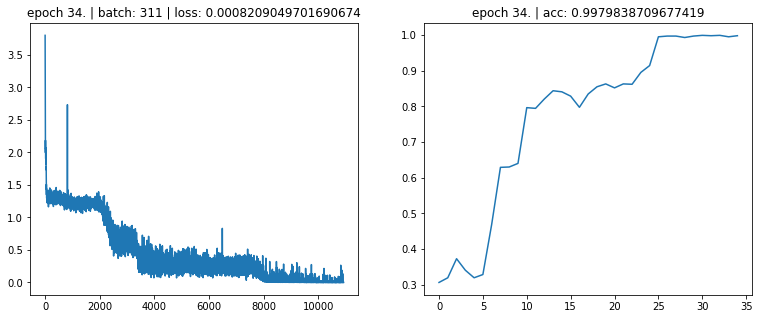

KeyboardInterrupt: 

In [226]:
trainer.train(1000)